# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Данный проект направлен на поиск модели, которая будет наиболее точно определять соимость автомобиля. 

## Подготовка данных

Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt  
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer, confusion_matrix, fbeta_score, mean_squared_error
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from pandas import DataFrame
import matplotlib.pyplot as plt
import time 
import lightgbm
from lightgbm import LGBMRegressor





Скачиваем данные

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.drop_duplicates()


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.shape

(354369, 16)

In [5]:
data.info

<bound method DataFrame.info of                 DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
0       2016-03-24 11:52:17    480          NaN              1993  manual   
1       2016-03-24 10:58:45  18300        coupe              2011  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
...                     ...    ...          ...               ...     ...   
354364  2016-03-21 09:50:58      0          NaN              2005  manual   
354365  2016-03-14 17:48:27   2200          NaN              2005     NaN   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        Power        Model  Kilometer  Regi

Сторим матрицу корреляции данных

                      Price  RegistrationYear     Power  Kilometer  \
Price              1.000000          0.026916  0.158872  -0.333199   
RegistrationYear   0.026916          1.000000 -0.000828  -0.053447   
Power              0.158872         -0.000828  1.000000   0.024002   
Kilometer         -0.333199         -0.053447  0.024002   1.000000   
RegistrationMonth  0.110581         -0.011619  0.043380   0.009571   
PostalCode         0.076055         -0.003459  0.021665  -0.007698   

                   RegistrationMonth  PostalCode  
Price                       0.110581    0.076055  
RegistrationYear           -0.011619   -0.003459  
Power                       0.043380    0.021665  
Kilometer                   0.009571   -0.007698  
RegistrationMonth           1.000000    0.013995  
PostalCode                  0.013995    1.000000  


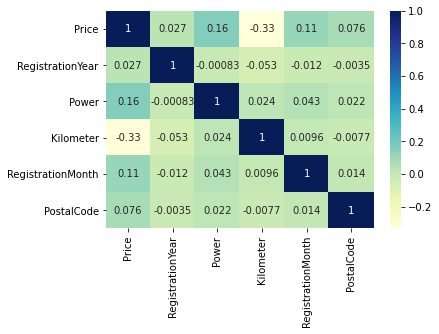

In [6]:
data_с = data.drop(['NumberOfPictures'], axis=1)
print(data_с.corr())  
data_plot = sns.heatmap(data_с.corr(), cmap="YlGnBu", annot=True)  

plt.show()

Для того, чтобы понять, какие признаки нам нужны, а какие нет, нужно понять условие заказчика, чтобы удалив ненужные признаки более точно заполнить информацию в столбцах.



Основная задача -  В нём можно будет узнать рыночную стоимость своего автомобиля. 

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику: 

качество предсказания;

время обучения модели;

время предсказания модели.

Список столбцов для изучения:\
DateCrawled — дата скачивания анкеты из базы\
VehicleType — тип автомобильного кузова\
RegistrationYear — год регистрации автомобиля\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Model — модель автомобиля\
Kilometer — пробег (км)\
RegistrationMonth — месяц регистрации автомобиля\
FuelType — тип топлива\
Brand — марка автомобиля\
Repaired — была машина в ремонте или нет\
DateCreated — дата создания анкеты\
NumberOfPictures — количество фотографий автомобиля\
PostalCode — почтовый индекс владельца анкеты (пользователя)\
LastSeen — дата последней активности пользователя

Столбцы, которые я считаю лишними для узечения модели:\
    То, что касается не автомоиля, а работы ресурса с данными:\
        DateCrawled - нам не важно, когда скачали анкету, потомучто мы оцениваем автомобиль.\
        DateCreated - теже причины\
        PostalCode - теже причины\
        LastSeen - теже причины\
    То, что касается автомобиля, но не его рыночной стоимости:\
            NumberOfPictures - я считаю, что это косвенный признак, который не нужен для расчетов стоимости. Для клиента это важный параметр, однако для модели бесполезный.
            

Итого - необходимые данные:\
VehicleType — тип автомобильного кузова\
RegistrationYear — год регистрации автомобиля\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Model — модель автомобиля\
Kilometer — пробег (км)\
RegistrationMonth — месяц регистрации автомобиля\
FuelType — тип топлива\
Brand — марка автомобиля\
Repaired — была машина в ремонте или нет


In [7]:
print(data['DateCreated'].sort_values(ascending=False))

323825    2016-04-07 00:00:00
238423    2016-04-07 00:00:00
218464    2016-04-07 00:00:00
8823      2016-04-07 00:00:00
136456    2016-04-07 00:00:00
                 ...         
175103    2015-08-10 00:00:00
86601     2015-08-07 00:00:00
342275    2015-06-18 00:00:00
4001      2015-03-20 00:00:00
61207     2014-03-10 00:00:00
Name: DateCreated, Length: 354369, dtype: object


In [8]:
data = data[['VehicleType', 'RegistrationYear','Gearbox','Power', 'Model','Kilometer','RegistrationMonth','FuelType','Brand','Repaired','Price']] 
data.drop_duplicates().dropna().reset_index(inplace=True, drop=True)


In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        316879 non-null  object
 1   RegistrationYear   354369 non-null  int64 
 2   Gearbox            334536 non-null  object
 3   Power              354369 non-null  int64 
 4   Model              334664 non-null  object
 5   Kilometer          354369 non-null  int64 
 6   RegistrationMonth  354369 non-null  int64 
 7   FuelType           321474 non-null  object
 8   Brand              354369 non-null  object
 9   Repaired           283215 non-null  object
 10  Price              354369 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [10]:
data.shape

(354369, 11)

In [11]:
data.info

<bound method DataFrame.info of         VehicleType  RegistrationYear Gearbox  Power        Model  Kilometer  \
0               NaN              1993  manual      0         golf     150000   
1             coupe              2011  manual    190          NaN     125000   
2               suv              2004    auto    163        grand     125000   
3             small              2001  manual     75         golf     150000   
4             small              2008  manual     69        fabia      90000   
...             ...               ...     ...    ...          ...        ...   
354364          NaN              2005  manual      0         colt     150000   
354365          NaN              2005     NaN      0          NaN      20000   
354366  convertible              2000    auto    101       fortwo     125000   
354367          bus              1996  manual    102  transporter     150000   
354368        wagon              2002  manual    100         golf     150000   

       

                   RegistrationYear     Power  Kilometer  RegistrationMonth  \
RegistrationYear           1.000000 -0.000828  -0.053447          -0.011619   
Power                     -0.000828  1.000000   0.024002           0.043380   
Kilometer                 -0.053447  0.024002   1.000000           0.009571   
RegistrationMonth         -0.011619  0.043380   0.009571           1.000000   
Price                      0.026916  0.158872  -0.333199           0.110581   

                      Price  
RegistrationYear   0.026916  
Power              0.158872  
Kilometer         -0.333199  
RegistrationMonth  0.110581  
Price              1.000000  


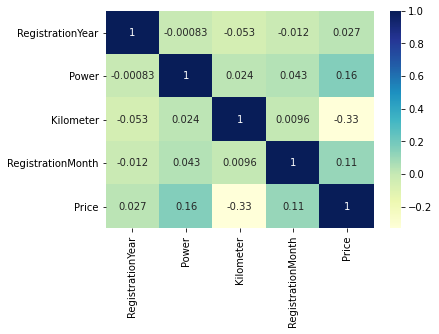

In [12]:
print(data.corr())  
data_plot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)  

plt.show()

In [13]:
data.isnull().sum()

VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
Price                    0
dtype: int64

In [14]:
print(data['Gearbox'].unique())

['manual' 'auto' nan]


Поиск аномалий 

VehicleType\
RegistrationYear\
Gearbox\
Power\
Model\
Kilometer\
FuelType\
Brand\
Repaired\
Price

In [15]:
print(data['RegistrationYear'].sort_values(ascending=False).unique())

[9999 9996 9450 9229 9000 8888 8500 8455 8200 8000 7800 7500 7100 7000
 6500 6000 5911 5900 5600 5555 5300 5000 4800 4500 4100 4000 3800 3700
 3500 3200 3000 2900 2800 2500 2290 2222 2200 2066 2019 2018 2017 2016
 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992 1991 1990 1989 1988
 1987 1986 1985 1984 1983 1982 1981 1980 1979 1978 1977 1976 1975 1974
 1973 1972 1971 1970 1969 1968 1967 1966 1965 1964 1963 1962 1961 1960
 1959 1958 1957 1956 1955 1954 1953 1952 1951 1950 1949 1948 1947 1946
 1945 1944 1943 1942 1941 1940 1938 1937 1936 1935 1934 1933 1932 1931
 1930 1929 1928 1927 1925 1923 1920 1919 1915 1910 1800 1688 1602 1600
 1500 1400 1300 1255 1253 1234 1200 1111 1039 1001 1000]


Есть года, которые не могут существовать. Это надо изменить. Наиболее правильный способ замены найти средний год выпуска похожих автомобилей. 

In [16]:
print(data['RegistrationMonth'].sort_values(ascending=False).unique())

[12 11 10  9  8  7  6  5  4  3  2  1  0]


Сразу проверим месяца, так как замена года и месяца схожи по параметрам.

Посмторим данные, которые для этого необходимы. 

VehicleType — тип автомобильного кузова\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Brand — марка автомобиля\


In [17]:
data.loc[(data['RegistrationYear'] > 2016), ('RegistrationYear')] = np.nan
data.loc[(data['RegistrationYear'] < 1910), ('RegistrationYear')] = np.nan
print(data['RegistrationYear'].sort_values(ascending=False).unique())
data.loc[(data['RegistrationMonth'] == 0), ('RegistrationMonth')] = np.nan
print(data['RegistrationMonth'].sort_values(ascending=False).unique())


[2016. 2015. 2014. 2013. 2012. 2011. 2010. 2009. 2008. 2007. 2006. 2005.
 2004. 2003. 2002. 2001. 2000. 1999. 1998. 1997. 1996. 1995. 1994. 1993.
 1992. 1991. 1990. 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981.
 1980. 1979. 1978. 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969.
 1968. 1967. 1966. 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957.
 1956. 1955. 1954. 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1945.
 1944. 1943. 1942. 1941. 1940. 1938. 1937. 1936. 1935. 1934. 1933. 1932.
 1931. 1930. 1929. 1928. 1927. 1925. 1923. 1920. 1919. 1915. 1910.   nan]
[12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1. nan]


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [18]:
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(data[['RegistrationYear']])
data['RegistrationYear'] = imputer.transform(data[['RegistrationYear']])

data['RegistrationYear'].unique()



/tmp/ipykernel_111/3360368892.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RegistrationYear'] = imputer.transform(data[['RegistrationYear']])


array([1993., 2011., 2004., 2001., 2008., 1995., 1980., 2014., 1998.,
       2005., 1910., 2016., 2007., 2009., 2002., 2003., 1997., 1990.,
       1981., 1994., 1991., 1984., 2006., 1999., 2012., 2010., 2000.,
       1992., 2013., 1996., 1985., 1989., 2015., 1982., 1976., 1983.,
       1973., 1969., 1971., 1987., 1986., 1988., 1970., 1965., 1945.,
       1925., 1974., 1979., 1955., 1978., 1972., 1968., 1977., 1961.,
       1960., 1966., 1975., 1963., 1964., 1954., 1958., 1967., 1959.,
       1956., 1941., 1962., 1929., 1957., 1940., 1949., 1937., 1951.,
       1953., 1933., 1950., 1948., 1952., 1932., 1942., 1935., 1936.,
       1923., 1930., 1944., 1943., 1934., 1938., 1928., 1919., 1931.,
       1915., 1920., 1947., 1927., 1946.])

In [19]:
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(data[['RegistrationMonth']])
data['RegistrationMonth'] = imputer.transform(data[['RegistrationMonth']])
data['RegistrationMonth'].unique()

/tmp/ipykernel_111/4179912079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RegistrationMonth'] = imputer.transform(data[['RegistrationMonth']])


array([ 6.,  5.,  8.,  7., 10., 12., 11.,  2.,  3.,  1.,  4.,  9.])

In [20]:
data.isnull().sum()

VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
Price                    0
dtype: int64

In [21]:
data_m = data[['Brand','Model']].drop_duplicates
print(data_m)
data_b = data[['Brand']].drop_duplicates().count()
print(data_b)


<bound method DataFrame.drop_duplicates of                  Brand        Model
0           volkswagen         golf
1                 audi          NaN
2                 jeep        grand
3           volkswagen         golf
4                skoda        fabia
...                ...          ...
354364      mitsubishi         colt
354365  sonstige_autos          NaN
354366           smart       fortwo
354367      volkswagen  transporter
354368      volkswagen         golf

[354369 rows x 2 columns]>
Brand    40
dtype: int64


In [22]:
print(data.head(15))
data.shape


    VehicleType  RegistrationYear Gearbox  Power    Model  Kilometer  \
0           NaN            1993.0  manual      0     golf     150000   
1         coupe            2011.0  manual    190      NaN     125000   
2           suv            2004.0    auto    163    grand     125000   
3         small            2001.0  manual     75     golf     150000   
4         small            2008.0  manual     69    fabia      90000   
5         sedan            1995.0  manual    102      3er     150000   
6   convertible            2004.0  manual    109  2_reihe     150000   
7         sedan            1980.0  manual     50    other      40000   
8           bus            2014.0  manual    125    c_max      30000   
9         small            1998.0  manual    101     golf     150000   
10        sedan            2004.0  manual    105  3_reihe     150000   
11        wagon            2005.0  manual    140   passat     150000   
12        wagon            1995.0  manual    115   passat     15

(354369, 11)

[    0     1     2 ... 19998 19999 20000]


<AxesSubplot:>

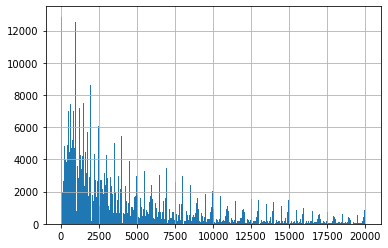

In [23]:
print(data['Price'].sort_values().unique())
data['Price'].hist(bins=300)

Цена не может быть 0вая, заменим 0е значения.

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158   159   160   161   162   163   

<AxesSubplot:>

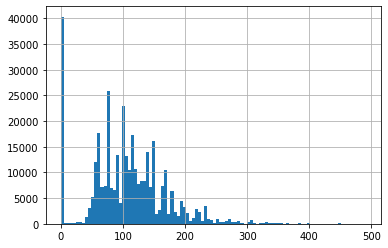

In [24]:
print(data['Power'].sort_values().unique())
hist = data[data['Power'] <500]
hist['Power'].hist(bins=100)

Также мощность не может быть 0й и вышее 500 лс уже вызывает подозрения. Заменим значения < 30  и > 500

In [25]:
data.loc[(data['Price'] == 0), ('Price')] = np.nan
data.loc[(data['Power'] < 30), ('Power')] = np.nan
data.loc[(data['Power'] > 500), ('Power')] = np.nan

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(data[['Price']])
data['Price'] = imputer.transform(data[['Price']])

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(data[['Power']])
data['Power'] = imputer.transform(data[['Power']])


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

<AxesSubplot:>

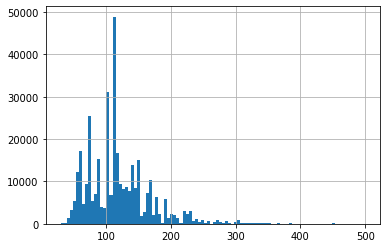

In [26]:

data['Power'].hist(bins=100)

In [27]:
data.isnull().sum()
print(data.shape)

(354369, 11)


In [28]:
print(data['VehicleType'].unique())
print(data['Gearbox'].unique())
print(data['Model'].unique())
print(data['FuelType'].unique())
print(data['Repaired'].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

In [29]:
f = lambda x: x.mode().iat[0] if x.notna().any() else np.nan    
data['Model'] = data.groupby('Brand', dropna=False)['Model'].transform(f)
data['VehicleType'] = data.groupby('Model', dropna=False)['VehicleType'].transform(f)
data['Gearbox'] = data.groupby('Model', dropna=False)['Gearbox'].transform(f)
data['FuelType'] = data.groupby('Model', dropna=False)['FuelType'].transform(f)
data['Repaired'] = data['Repaired'].fillna('non_stated')


data.isnull().sum()


/tmp/ipykernel_111/3415496181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Model'] = data.groupby('Brand', dropna=False)['Model'].transform(f)
/tmp/ipykernel_111/3415496181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['VehicleType'] = data.groupby('Model', dropna=False)['VehicleType'].transform(f)
/tmp/ipykernel_111/3415496181.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                3374
Kilometer               0
RegistrationMonth       0
FuelType                0
Brand                   0
Repaired                0
Price                   0
dtype: int64

Способ замены - выбор наиболее распространненого признака относительно 

После замены остались еще строки, в которых есть незаполненные пропуски, их удалим из выборки. 

In [30]:
print(data.shape)
data = data.dropna()
data.isnull().sum()

(354369, 11)


VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
Price                0
dtype: int64

In [31]:
data.shape

(350995, 11)

Во время предобработки данных:
    1 Установлены необходимые библиотеки
    2 Обработаны данные
    3 Удалены лишние признаки
    4 Заполнены пропуски


## Обучение моделей

Создаем признаки и таргет

In [32]:
features = data.drop(['Price'], axis = 1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target,test_size=0.25, random_state=12345)

encoder = OrdinalEncoder(handle_unknown='ignore')
encoder.fit(features_train)
features_train = pd.DataFrame(encoder.transform(features_train))
features_test =  pd.DataFrame(encoder.transform(features_test))



Настраиваем 1 модель

In [33]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20 ],
    'max_features': [3],
    'n_estimators': [80, 100, 120]
}

rf = RandomForestRegressor()
start = time.time()
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, scoring= 'neg_mean_squared_error', cv = 2, n_jobs = -1, verbose = 2).fit(features_train, target_train)
end_fit_rfr = time.time() - start
print("Время работы модели Fit:", end_fit_rfr)
best_parameters_final = grid_search_final.best_params_
best_estimator_final = grid_search_final.best_estimator_
cv_rfc_final = cross_val_score(best_estimator_final,features_train, target_train, scoring= 'neg_mean_squared_error' , cv=4).mean()
print(best_parameters_final)
print(abs(cv_rfc_final)**(0.5))

start = time.time()
bf = best_estimator_final.predict(features_train)
end_predict_rfr = time.time() - start
print("Время работы модели Predict:", end_predict_rfr)


Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END bootstrap=True, max_depth=10, max_features=3, n_estimators=80; total time=   5.9s
[CV] END bootstrap=True, max_depth=10, max_features=3, n_estimators=80; total time=   5.6s
[CV] END bootstrap=True, max_depth=10, max_features=3, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=10, max_features=3, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=10, max_features=3, n_estimators=120; total time=   8.5s
[CV] END bootstrap=True, max_depth=10, max_features=3, n_estimators=120; total time=   8.1s
[CV] END bootstrap=True, max_depth=15, max_features=3, n_estimators=80; total time=   8.1s
[CV] END bootstrap=True, max_depth=15, max_features=3, n_estimators=80; total time=   8.0s
[CV] END bootstrap=True, max_depth=15, max_features=3, n_estimators=100; total time=  10.0s
[CV] END bootstrap=True, max_depth=15, max_features=3, n_estimators=100; total time=   9.8s
[CV] END bootstrap=True,

Настраиваем модель LightGBM

In [34]:
train_data = lightgbm.Dataset(features_train, label=target_train, 
                              free_raw_data=False,
                             )

param_grid = {'learning_rate': [0.1, 0.3],
              'max_depth': [15, 20],
             }

lgbm = lightgbm.LGBMRegressor(n_jobs = 4)

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )




In [35]:
start = time.time()
grid_search.fit(features_train, target_train)
end_fit_lgbm = time.time() - start
print(grid_search.best_params_)

print('RMSE для LightGBM модели на валидационной выборке: {:.2f}'.format((-grid_search.best_score_) ** 0.5))
start = time.time()
prediction = grid_search.predict(features_train)
end_prdict_lgbm = time.time() - start

{'learning_rate': 0.3, 'max_depth': 15}
RMSE для LightGBM модели на валидационной выборке: 1904.77


In [36]:

mse = mean_squared_error(target_train, prediction)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("Время работы модели Fit:", end_fit_lgbm)
print("Время работы модели Predict:", end_prdict_lgbm)


MSE: 3368757.31
RMSE: 1835.42
Время работы модели Fit: 35.366201877593994
Время работы модели Predict: 1.4982447624206543


Основные показатели моделей. 

In [37]:
print('Модель RandomForest')
print("Время работы модели Fit:", end_fit_rfr)
print(abs(cv_rfc_final)**(0.5))
print("Время работы модели Predict:", end_predict_rfr)
print()
print('Модель LGBM')
print("RMSE: %.2f" % rmse)
print("Время работы модели Fit:", end_fit_lgbm)
print("Время работы модели Predict:", end_prdict_lgbm)

Модель RandomForest
Время работы модели Fit: 210.74288296699524
1866.8967125396573
Время работы модели Predict: 4.804383277893066

Модель LGBM
RMSE: 1835.42
Время работы модели Fit: 35.366201877593994
Время работы модели Predict: 1.4982447624206543


## Анализ моделей

Модель с наименьшим RSME - LightGBMRegressor. Проверим на тест данных.

In [38]:
bf = grid_search.predict(features_test)
result = mean_squared_error(target_test, bf)**0.5 
print(result)

dummy_regr = DummyRegressor(strategy="mean")
fin = dummy_regr.fit(features_train, target_train)
fin = fin.predict(features_test)
result = mean_squared_error(target_test, fin)**0.5 
print("RMSE dummy:", result)

1901.968849094846
RMSE dummy: 4452.857878337614


Итог:
    
Наша модель лучше, чем модель дамми. 

В данном проекте были обработаны данные по продажам автомобилям. 
Обработаны данные для корректного прогнозирования модели
Проверено 2 модели - RandomForestRegressor и LightGBM
Выбрана 1 лучшая модель - LightGBMRegressor

